# <center>Matching models with imperfectly transferable utility</center>
### <center>Alfred Galichon (NYU & Sciences Po)</center>
## <center>'math+econ+code' masterclass series</center>
#### <center>With python code examples</center>
© 2018–2023 by Alfred Galichon. Past and present support from NSF grant DMS-1716489, ERC grant CoG-866274 are acknowledged, as well as inputs from contributors listed [here](http://www.math-econ-code.org/team).

**If you reuse material from this masterclass, please cite as:**<br>
Alfred Galichon, 'math+econ+code' masterclass series. https://www.math-econ-code.org/


# References

* Gabrielle Demange and David Gale (1985). "The Strategy Structure of Two-Sided Matching Markets". *Econometrica*  53 no. 4, pp. 873-888.
* Alvin Roth and Marilda Sotomayor (1990). *Two-sided matching. A Study in Game-Theoretic Modeling and Analysis.* Econometric Society Monographs.
* Alfred Galichon, Scott Kominers, and Simon Weber (2019). "Costly Concessions: An Empirical Framework for Matching with Imperfectly Transferable Utility." *Journal of Political Economy* 127 no. 6, pp. 2875-2925.


# Matching with nonlinear taxes

## Generating the data

We will generate the same type of worker/firm data as yesterday.

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


np.random.seed(777)
d = 8
nbx = 50
nby = 30

rg = .8
rs = .6
r  = .7

n_x = np.ones(nbx)
m_y = np.ones(nby)
ξ_x_k = np.random.rand(nbx,d)
ζ_y_k = np.random.rand(nby,d)

α_x_y = np.zeros((nbx,nby))
γ_x_y = np.zeros((nbx,nby))
for x in range(nbx):
    for y in range(nby):
        α_x_y[x,y] = -  np.linalg.norm(ξ_x_k[x,6:7]-ζ_y_k[y,6:7])-5
        γ_x_y[x,y] = 10+5*(np.sum( (ξ_x_k[x,0:3]*ζ_y_k[y,0:3])**rg )**(r/rg)+(  np.sum(  ξ_x_k[x,3:6]*ζ_y_k[y,3:6] )**rs )**(r/rs))**r
        
Φ_x_y = α_x_y + γ_x_y

## Tax schedule

In 2020, the federal tax schedule for a single taxpayer was as follows: 

|MARGINAL RATE | LOWER BRACKET | UPPER BRACKET  | TAX OWED  |
| :----- | :----- | :----- | :------------------------------------------------------------- |
| 10\% | \$0  | \$9,700    | 10\% of taxable income |
| 12\% | \$9,701 | \$39,475 | \$970 plus 12\% of the excess over \\$9,700 |
| 22\% | \$39,476 | \$84,200 | \$4,543 plus 22\% of the excess over \\$39,475 |
| 24\% | \$84,201 | \$160,725 | \$14,382.50 plus 24\% of the excess over \\$84,200 |
| 32\% | \$160,726 | \$204,100 | \$32,748.50 plus 32\% of the excess over \\$160,725 |
| 35\% | \$204,101 | \$510,300 | \$46,638.50 plus 35\% of the excess over \\$204,100 |
| 37\% | \$510,300 | - | \$153,798.50 plus 37\% of the excess over \\$510,300 |

(Source: https://www.investopedia.com/terms/t/taxbracket.asp)

Let $N\left( w\right) $ be the net wage if gross wage is $w$.

Let $\tau ^{k}$ be the $k$-th tax rate (by increasing order), and $w^{k}$ be the lower bracket associated with $\tau_k$.

Set $w^{0}=0,n^{0}=0,\tau ^{0}=0.1$.

Letting $n^k=N(w^k)$, one has<br>
$n^{k+1}=n^{k}+\left( 1-\tau ^{k}\right) \left( w^{k+1}-w^{k}\right) $<br>
and<br>
$N\left( w\right) =\min_{k}\left\{ n^{k}+\left( 1-\tau ^{k}\right) \left(
w-w^{k}\right) \right\} $


Let $g$ be the gross wage, and $n$ be the net wage, we have that the net wage is a piecewise linear, increasing and concave function of the gross wage, whose slopes are $1-\tau_k$, so it expresses as<br>
$ n = \min_k \{N^k+(1-\tau_k) w\}$<br>
where $N^k = n^k - w^k (1-\tau^k) = \tau^k w^k - (n^k - w^k)$.<br> 

We encode this as:

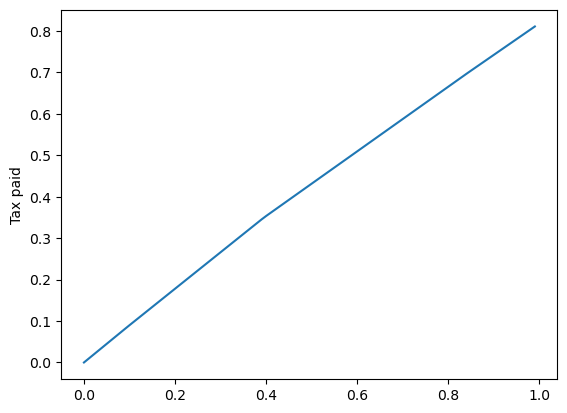

In [2]:
lower_bracket = np.array([0, 9.701, 39.476, 84.201, 160.726, 204.101, 510.300])/100
marginal_tax =  np.array([.1,.12,   .22,    .24,    .32,     .35,     .37    ])
tax_on_previous_brackets = np.zeros(lower_bracket.size)
for i in range(1,lower_bracket.size):
    tax_on_previous_brackets[i] = tax_on_previous_brackets[i-1] + marginal_tax[i-1]*(lower_bracket[i]-lower_bracket[i-1])
    
N_k = np.append(0,marginal_tax*lower_bracket - tax_on_previous_brackets ) 
τ_k = np.append(0,marginal_tax)
nbk =N_k.size

TaxPaid = np.vectorize(lambda g : max(g*τ_k -N_k))
NetFromGross = np.vectorize(lambda g : min(N_k+g*(1-τ_k)))

gs = np.arange(0,1,0.01)
ts = NetFromGross(gs)
plt.plot(gs,ts)
plt.ylabel('Tax paid')
plt.show()

# Bargaining whithin a pair
In order to study the matching problem, we need to first study the bargaining possibilities within a matched pair. For now we shall drop the subscripts $x$ and $y$, and we will study the set of utilities $(U,V)$ that the worker and the firm can obtain as an outcome of that bargaining. This set is called *feasible utility set*, or *bargaining set*.

Most of the material in this lecture is taken from Galichon, Kominers and Weber (2019).

## Feasible utilities

For each value of $w$ (nominal wage), compute<br>
$\left\{
\begin{array}{l}
U \text{ = utility of the worker}\\
V\text{ = utility of the firm}
\end{array}
\right.$

In the transferable utility case (Becker-Shapley-Shubik),<br>
$\left\{
\begin{array}{l}
U(w) = \alpha + w\\
V(w) = \gamma -w,
\end{array}
\right.$<br>
but in general, we shall assume that $\mathcal{U}\left( w\right)$ and $\mathcal{U}\left( w\right)$  are nondecreasing (resp. nonincreasing) and continuous, not necessarily linear.



## The feasible utility set
Given a worker-firm pair, define $\mathcal{F}$ the feasible utility set as:

$\mathcal{F}=\left\{ \left( U,V\right) :\exists w,U\leq U\left(
w\right) ,V\leq V\left( w\right) \right\} $.

equivalently, if $\mathcal{U}$ is strictly increasing

$\mathcal{F}=\left\{ \left( U,V\right) :V\leq V\left( U
^{-1}\left( U\right) \right) \right\} .$

Note that we are assuming free disposal: if $(U,V)$ is feasible and if $U' \leq U$ and $V' \leq V$, then $(U',V')$ is feasible.

Also, $w$ does not have to be a wage; it can be the set of terms of a contract.

## Frontier of the feasible utility set

We define the *frontier* of the feasible utility sets as the set of points $(U,V)\in \mathcal{F}$ such that there is no point $(U',V')\in \mathcal{F}$ with<br>
$U' < U$ and $V' < V$.

**Caution here**. This coincides with the *topological frontier* which is defined as the intersection of the closures of the interior and exterior of the set, but not with the *set of Pareto efficient points*, which is in general a subset of the former. Indeed, the set of Pareto efficient points is the set of points $(U,V)\in \mathcal{F}$ such that there is no point $(U',V')\in \mathcal{F}$ with<br>
$U' \leq U$ and $V' \leq V$, with at least one strict inequality.<br>
In particular, if $\mathcal{F} = (U,V): U\leq 1~and~V\leq 1$, the topological frontier is union of the set $\{U=1,V\leq 1\}$ and $\{U\leq 1, V=1\}$, while the set of Pareto efficient points is $(1,1)$.<br>
This distinction will be important when we discuss model with non-transferable utility.


## Distance-to-frontier function


Given a feasible set $\mathcal{F}$, compute the distance to the frontier of $\mathcal{F}$ along the diagonal, with a minus sign if in the interior, and a plus sign if it is not.<br>
<br>
Define the *distance-to-frontier* function as<br>
$D(U,V)=\min\{t∈R:(U-t,V-t)∈F\}$<br>

This way:<br>
$D(U,V) \leq 0 $ means that $(U,V)\in\mathcal{F},$<br>
while<br>
$D(U,V) = 0 $ means that $(U,V)$ is on the frontier of $\mathcal{F}$.

**Property**. For $a \in \mathbb{R}$, we have $D(U+a,V+a)=D(U,V)+a$.
    


## Parameterization of the frontier of the feasible set

We can define $\delta = U-V$ and get an explicit parameterization on the frontier of the feasible set as a function of $\delta$.<br> 
$D(\mathcal{U}(\delta) , \mathcal{U}(\delta) - \delta) =0$ and<br>
$D(\mathcal{V}(\delta) + \delta, \mathcal{V}(\delta) ) =0$<br> 
thus<br>
$\left\{
\begin{array}[l]
~\mathcal{U}\left( \delta \right) = - D(0,-\delta)\\
\mathcal{V}\left( \delta \right) = - D(\delta,0)
\end{array}
\right.
$<br>


In [34]:
Ucalf = lambda D: (lambda w: -D(0,-w) )
Vcalf = lambda D: (lambda w: -D(w,0) )

def plot_feasible(D,range = (-1,1)):
    δs = np.linspace(range[0],range[1],num=500)
    Ucal,Vcal = np.vectorize(Ucalf(D)),np.vectorize(Vcalf(D))
    us = [Ucal(δ) for δ in δs]
    vs = [Vcal(δ) for δ in δs]
    umin,vmin = min(us),min(vs)
    umax,vmax = max(us),max(vs)
    plt.figure(figsize=(4, 4))
    plt.xlim([umin, umax+(umax-umin)/3])
    plt.ylim([vmin, vmax+(vmax-vmin)/3])
    plt.plot(us,vs)
    plt.xlabel('U')
    plt.ylabel('V')
    plt.fill(us+[np.min(us)],vs+[np.min(vs)])
    
    
    plt.show()


## Some examples
### Example 1:  transferable utility (TU)
 
* The Becker model assumes  *additively transferable utility*: it is a model of marriage in which utility can freely be transferred across partners, in a one-to-one manner.<br>
$\left\{
\begin{array}
\mathcal{U}\left( w\right) =\alpha +w \\
\mathcal{V}\left( w\right) =\gamma -w
\end{array}
\right.
$<br>
and thus, denoting $\Phi = \alpha +\gamma$,<br>
$\mathcal{F}=\left\{ \left( U,V\right) :u+v\leq \Phi \right\} $<br>


* The distance=to-frontier in the transferable utility case is<br>
$D(U,V) = \frac {U+V - \Phi} {2}.$

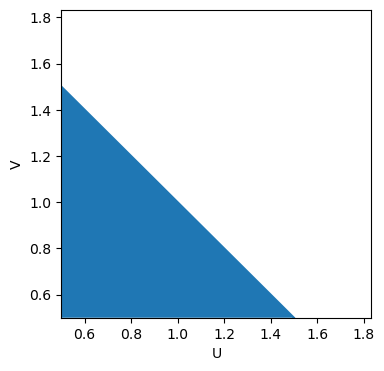

In [35]:
def create_D_TU(Φ):
    return (lambda U,V : (U+V - Φ)/2)

plot_feasible(create_D_TU(2))

### Example 2: non-transferable utility (NTU)

* **Motivation: housing market with price controls.** In the model of *non-transferable utility,* no transfer attempt can be beneficial to the other side of the market. In that case, denote $(\alpha,\gamma)$ the only Pareto efficient point, and due to free disposal:<br>
$\mathcal{F=}\left\{ \left( U,V\right) :U\leq \alpha \text{ and }V\leq
\gamma \right\}. $<br>

* The distance-to-frontier is the scalar $t\in\mathbb{R}$ such that
$\max \left( U-\alpha ,V-\gamma \right) -t = 0$, hence:<br>
$D\left( U,V\right) =\max \left( U-\alpha ,V-\gamma \right) $<br>



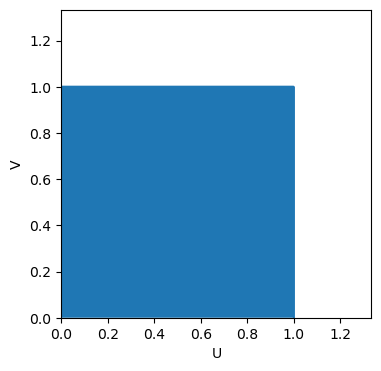

In [36]:
def create_D_NTU(α,γ):
    return (lambda U,V : np.maximum(U - α ,V -γ ))

plot_feasible(create_D_NTU(1,1))

### Example 3: linearly transferable utility (LTU)

* **Motivation: labor matching with flat tax**. Consider a model of the labor market with proportional taxation, where the tax rate is $\tau$. We have<br>
$ U-\alpha = (1 - \tau) (\gamma - V) $<br>
then, setting $\lambda = 1 /(2 - \tau)$, one has<br>
$\mathcal{F=}\left\{ \left( U,V\right) :\lambda U + (1-\lambda) V \leq  \Phi \right\},$<br>
where $\Phi = \lambda \alpha + (1-\lambda) \gamma $.

* As a result, the distance function is<br>
$D(U,V) = \lambda U + (1-\lambda) V - \Phi).$

In [39]:
def create_D_LTU(α,γ,λ):
    return (lambda U,V : λ*(U-α)+(1-λ)*(V-γ))
gross_wages = lower_bracket / 10
net_wages = NetFromGross(lower_bracket)/10
D_LTUs = [create_D_LTU(  net_wages[i] , 1 - gross_wages[i], 1/(2-marginal_tax[i]) ) for i in range(len(marginal_tax))]

### Example 4: exponentially transferable utility (ETU)

* **Motivation: household bargaining with private consumption.** We consider a model of marriage in which we model intra-household bargaining with private consumption and match amenity.

* A match yield amenity $\alpha$ to man $i$ and utility $\gamma$ to woman $j$, and private consumptions are denoted $c^{i}$ and $c^{j}$.<br>

* The utilities are formed as a combination of the log-consumptions and the match amenities:<br>
 $\left\{
\begin{array}[l]
~U = \tilde{\alpha} +\tau \log c^{i}\\
V = \tilde{\gamma} +\tau \log c^{j}
\end{array}
\right.
$<br>
where the private consumptions are subject to the budget constraint $c^{i}+c^{j}=B$, where $B$ is the joint budget of the household.<br>

* We have $c^{i}=\exp \left( \frac{U-\tilde{\alpha} }{\tau }\right) $ and $c^{j}=\exp \left( \frac{V-\tilde{\gamma} }{\tau }\right) $ and thus the budget constraint rewrites:<br>
$\exp \left( \frac{U- \tilde{\alpha} }{\tau }\right) +\exp \left( \frac{V-\tilde{\gamma} }{\tau }\right) \leq B$<br>
and setting $\alpha = \tilde{\alpha} + \tau \log B$ and $\gamma = \tilde{\gamma} + \tau \log B$, we obtain:<br>
$\mathcal{F=}\left\{ \left( U,V\right) :\exp \left( \frac{U- \alpha }{\tau }%
\right) +\exp \left( \frac{V-\gamma }{\tau }\right) \leq 2\right\} $<br>

* The distance function can be obtained as<br> 
$D(U,V) = \tau \log \left( \frac {\exp(\frac{ U-\alpha} {\tau} ) + \exp(\frac {V - \gamma} {\tau}) } {2} \right)$

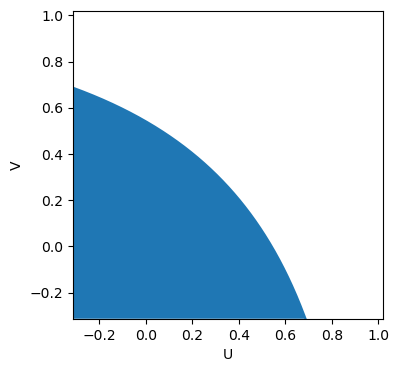

In [38]:
def create_D_ETU(α,γ,τ):
    return (lambda U,V : τ * np.log(np.exp( (U - α ) / τ ) + np.exp ((V -γ ) / τ )) )

plot_feasible(create_D_ETU(1,1,1))


### Example 4 (continued): limits of the ETU case
**Remarks.**
* When $\tau \rightarrow +\infty $, we get at first order in $1 / \tau$<br>

    $2+\frac{U-\alpha }{\tau }+\frac{V-\gamma }{\tau }\leq 2$<br>

    which in the limit of a very large $\tau$, yields $U+V\leq \alpha +\gamma $, the transferable utility case.<br>

* When $\tau \rightarrow 0$, we get<br>
    $\tau \log \left( \exp \left( \frac{U-\alpha }{\tau }\right) +\exp \left( 
\frac{V-\gamma }{\tau }\right) \right) \leq \tau \log 2$<br>

    which in the limit when $\tau$ tends to zero, yields $\max \left\{ U-\alpha ,V-\gamma \right\} \leq 0$, the non-transferable utility case.<br>


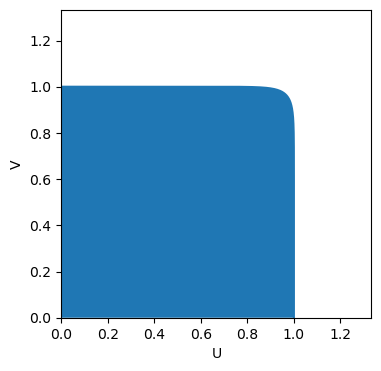

In [40]:
plot_feasible(create_D_ETU(1,1,0.05))

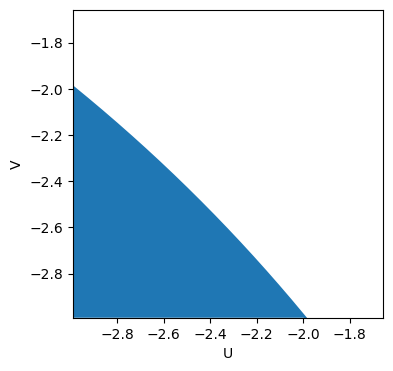

In [41]:
plot_feasible(create_D_ETU(1,1,5))

### Example 5: union of feasible sets

* **Motivation: household bargaining with public goods**. Consider a model of marriage where partners make a joint decision on a public good $g\in G$ e.g. the number of kids; buying a house, etc.<br>

* Assume that conditional on $g\in G$, the utilities are<br>
 $\left\{
\begin{array}[l]
~U=\alpha ^{g}\left( w\right)\text{ increasing}\\
V=\gamma ^{g}\left( w\right)\text{ decreasing}
\end{array}
\right.
$<br>
where $w$ is the term of match - say the share of private consumption that
goes to the man.<br>

* We can compute the *conditional feasible set*<br>
$\mathcal{F}^{g}\mathcal{=}\left\{ \left( U,V\right) :U\leq \alpha
^{g}\left( \left( \gamma ^{g}\right) ^{-1}\left( V\right) \right) \right\} $<br>

* The overall feasible set is the union of the conditional bargaining sets:<br>
$\mathcal{F=\cup }_{g\in G}\mathcal{F}^{g}$.<br>
$\mathcal{F=}\left\{ \left( U,V\right) :U\leq \max_{g}\alpha ^{g}\left(
\left( \gamma ^{g}\right) ^{-1}\left( V\right) \right) \right\} $<br>

* The distance function associated with the overall set is the minimum of the distance functions associated with the conditional bargaining sets:<br>
$D_{\mathcal{F}}\left( U,V\right) =\min_{g}D_{\mathcal{F}^{g}}\left(
U,V\right) $.

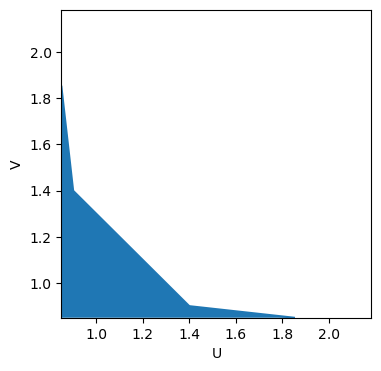

In [59]:
def create_D_union(Dlist):
    return (lambda U,V : min([D(U,V) for D in Dlist]) )

D_LTUs_bis  = [create_D_LTU(  a , b, c ) for (a,b,c) in [(0.95,0.95,0.1),(0.95,0.95,0.9),(1.15,1.15,0.5)]]


plot_feasible(create_D_union(D_LTUs_bis))


### Example 6: intersection


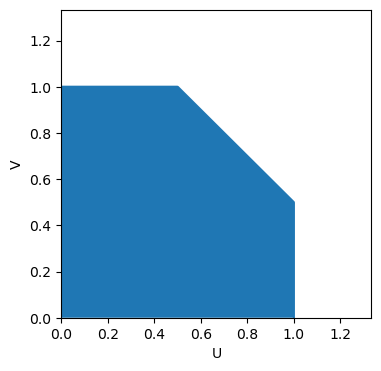

In [60]:
def create_D_inter(Dlist):
    return (lambda U,V : max([D(U,V) for D in Dlist]) )


D_LTUs_ter  = [create_D_LTU(  a , b, c ) for (a,b,c) in [(1,1,0),(1,1,1),(0.75,0.75,0.5)]]
plot_feasible(create_D_inter(D_LTUs_ter))


### Example 6: progressive taxation

* **Motivation: labor matching with progressive taxation.**
In the case of progressive taxation as introduced above,<br>
$\left\{
\begin{array}{l}
~U\left( w_{xy}\right) =\alpha +N\left( w\right) = \alpha
+\min_{k}\left\{ n^{k}+\left( 1-\tau _{k}\right) \left( w-w^{k}\right)
\right\}\\
V \left( w_{xy}\right) =\gamma _{xy}-w_{xy}
\end{array}
\right.$<br>

* We have therefore<br>
$\mathcal{F=\cap }_{k}\mathcal{F}^{k}$<br>
where<br>
$\mathcal{F}^{k}=\left\{ \left( U,V\right) : \frac {U - \alpha - n^{k}} { 2 -\tau^k} +  \frac 
{1-\tau ^{k}} {2 - \tau^k} \left( V - \gamma + w^{k}\right) \leq 0 \right\} $ which is the feasible set associated with a LTU model

* Letting $\tilde{\alpha}_k = \alpha + n^{k}$ and $\tilde{\gamma}_k=\gamma - w^{k}$, and $\lambda^k = \frac {1} {2 - \tau^k}$, the distance function can be expressed as:<br>
$D_{\mathcal{F}}\left( U,V\right) =\max_{k} \left\{ \lambda^k (U-\tilde{\alpha}^k) + (1-\lambda^k) (V - \tilde{\gamma}^k) \right\} $



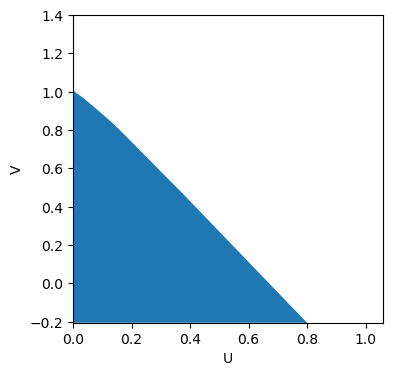

In [62]:
def create_D_inter(Dlist):
    return (lambda U,V : max([D(U,V) for D in Dlist]) )

plot_feasible(create_D_inter(D_LTUs))

# The matching model without heterogeneity

Assume $w_{xy}$ is the wage and consider the workers' and the firms' problems. Define the indirect utilities as:<br>
$u_{x}=max_{y}\{U_{xy}(w_{xy}),0\}$ and $v_{y}=max_{x}\{V_{xy}(w_{xy}),0\}$
    
$(\mu,u,v,w)$ is an equilibrium matching if the following conditions hold

(i) population constraint
    
$\sum_{y}\mu_{xy}+\mu_{x0}=n_{x}$ and $\sum_{x}\mu_{xy}+\mu_{0y}=m_{y}$
    
(ii) Stability

$u_{x}\geq U_{xy}(w_{xy})$ and $v_{y}\geq V_{xy}(w_{xy})$, and

$u_{x}\geq0$ and $v_{y}≥0$

(iii) Complementarity

$\mu_{xy}>0$ implies $u_{x}=U_{xy}(w_{xy})$ and $v_{y}=V_{xy}(w_{xy})$<br>
$\mu_{x0}>0$ implies $u_{x}=0$, and  $\mu_{0y}>0$ implies $v_{y}=0$.

## Equilibrium formulation (model without heterogeneity)
Note that we can remove $w_{xy}$ by rewriting stability as $D_{xy}(u_x,v_y) \geq 0$. Equilibrium can be reexpressed as:<br>
(i) population constraint<br> 
$\sum_{y}\mu_{xy}+\mu_{x0}=n_{x}$ and $\sum_{x}\mu_{xy}+\mu_{0y}=m_{y}$
    
(ii) Stability<br>
$D_{xy}(u_x,v_y) \geq 0$
$u_{x}\geq0$ and $v_{y}≥0$

(iii) Complementarity<br>
$\mu_{xy}>0$ implies  $D_{xy}(u_x,v_y) = 0$<br>
$\mu_{x0}>0$ implies $u_{x}=0$, and  $\mu_{0y}>0$ implies $v_{y}=0$.

# The matching model with logit heterogeneity

* As before, we introduce $(\varepsilon_y)$ and $(\eta_x)$ two random utility terms with an i.i.d. Gumbel distribution. Denote $U_{xy}=U_{xy}(w_{xy})$ and $V_{xy}=V_{xy}(w_{xy})$. The average indirect utilities are:<br>
$\left\{
\begin{array}[l]
~u_{x}= \mathbb{E}[\max_{y}\{U_{xy}+T\epsilon_{y},T\epsilon_0\}] = T\log(1+∑_{y}\exp(U_{xy}/T))\\
v_{y}= \mathbb{E}[\max_{x}\{V_{xy}+T\eta_{x},T\eta_0\}] = T\log(1+\sum_{x}\exp(V_{xy}/T))
\end{array}
\right.
$

* The choice probabilities are<br>
$\Pr(y|x) = \exp( (U_{xy} - u_x) / T)$ and $\Pr(0|x) = \exp(  - u_x / T)$<br>
$\Pr(x|y) = \exp( (V_{xy} - v_y) / T)$ and $\Pr(0|y) = \exp(  - v_y / T)$.

* Note that we have $(U_{xy},V_{xy})\in \mathcal{F}_{xy}$. Thus, we reexpress
$U_{xy}=U_{xy}(w_{xy})$ and $V_{xy}=V_{xy}(w_{xy})$ for some $w_{xy}$ as<br>
$D_{xy}(U_{xy},V_{xy})=0$<br>
where $D_{xy}$ is the distance function associated with $\mathcal{F}_{xy}$.



## The matching equations

* We have<br>
$\left\{
\begin{array}[l]
~U_{xy} = T \ln \mu_{xy} - T \ln  \mu_{x0}\\
 V_{xy} = T \ln \mu_{xy}  - T \ln  \mu_{0y},
\end{array}
\right.$<br>
and therefore<br>
$D_{xy}(T \ln \mu_{xy} - T \ln  \mu_{x0},T \ln \mu_{xy}  - T \ln  \mu_{0y})=0$<br>
hence<br>
$\mu_{xy}=M_{xy}(\mu_{x0},\mu_{0y})$, where $M_{xy}$ is the *matching equation*, given as:<br>
$M_{xy}(\mu_{x0},\mu_{0y}):=\exp(- D_{xy}(-T\ln \mu_{x0},-T\ln \mu_{0y}) / T)$


* The equations of the model become:<br>
$\left\{
\begin{array}[l]
~\mu_{x0}+∑_{y\in \mathcal{Y}}M_{xy}(\mu_{x0},\mu_{0y}) = n_{x}\\
\mu_{0y}+∑_{x\in\mathcal{X}}M_{xy}(\mu_{x0},\mu_{0y}) = m_{y}
\end{array}
\right.$

# Solving for the equilibrium using Gauss-Seidel

We will verify that we are in the Gross Substitutes / BGH case. Recall

$M_{xy}(\mu_{x0},\mu_{0y})=\exp(-D_{xy}(-T\ln \mu_{x0},-T\ln \mu_{0y}) / T)$

Introduce $p_{z}=(p_{x},p_{y})$ with $p_{x}=-\mu_{x0}$ and $p_{y}=\mu_{0y}$,

$\left\{
\begin{array}[l]
~Q_{x}(p) = p_{x}-∑_{y∈Y}M_{xy}(-p_{x},p_{y})+n_{x}\\
Q_{y}(p) = p_{y}+∑_{x∈X}M_{xy}(-p_{x},p_{y})-m_{y}
\end{array}
\right.$

Gross substitutes hold.
    
Law of aggregate supply holds:<br>
$\sum_{x}Q_{x}(p)+∑_{y}Q_{y}(p)=∑_{x}p_{x}+∑_{y}p_{y}+∑_{x}n_{x}-\sum_{y}m_{y}$ is increasing in all the prices.
    
Hence $Q$ is inverse isotone.
    
Now let's see that there is a subsolution and a supersolution.

$p_{z}=N$, $N$ large enough yields a supersolution, while $p_{z}=-N$, N large enough yields a subsolution.
    
Hence there is a solution, and Gauss-Seidel converges.

## The class `GKW_model`
### Distance function
Note that $n_{xy} \leq \min_k \{N_k+(1-\tau_k) g_{xy}\}$ is equivalent to $$ \frac{- N_k - (1-\tau_k) g_{xy} + n_{xy}} {2 - \tau_k} \leq 0~\forall k.$$
As $n_{xy}=U_{xy}-\alpha_{xy}$ and $g_{xy} = \gamma_{xy} -V_{xy}$, this is equivalent to $$ \frac{ (U_{xy} - \alpha_{xy} ) + (1-\tau_k) ( V_{xy} - \gamma_{xy}) -N_k } {2 - \tau_k} \leq 0~\forall k, $$
therefore, we get
$$ D_{xy}(U,V) = \max_k \left\{ \frac{ (U - \alpha_{xy} ) + (1-\tau_k) ( V - \gamma_{xy}) -N_k } {2 - \tau_k} \right\} $$
or,  setting<br>
$\lambda_k = 1 /  (2 - \tau_k)$ and<br>
$\nu_k = (1 - \tau_k) /  (2 - \tau_k)$ and<br>
$\Phi^k_{xy} = \lambda_k (\alpha_{xy}+N_k) + \nu_k \gamma_{xy}$<br>
$$ D_{xy}(U,V) = \max_k \left\{ \lambda_k U + \nu_k V -  \Phi^k_{xy} \right\} $$
### Matching function
One has $$M_{xy}(\mu_{x0},\mu_{0y})=\exp(-D_{xy}(-\log \mu_{x0},-\log \mu_{0y}))=\min_k \left\{ \mu_{x0}^{\lambda_k}  \mu_{0y}^ {\nu_k} e^{ \Phi^k_{xy}} \right\}  $$

In [ ]:
λ_k = 1 / (2-τ_k)
ν_k = (1-τ_k) / (2-τ_k)
Φ_k_x_y = np.zeros((nbk,nbx,nby))
for k in range(nbk):
    for x in range(nbx):
        for y in range(nby):
            Φ_k_x_y[k,x,y] = λ_k[k]*(α_x_y[x,y]+N_k[k])+ν_k[k] * γ_x_y[x,y]

class GKW_model:    
    def __init__(self):
        self.n_x = n_x
        self.m_y = m_y
        self.nbx = n_x.size
        self.nby = m_y.size
        self.eq_μ_x0 = np.array([])
        self.eq_μ_0y = np.array([])
        self.eq_μ_x_y = np.array([])
        self.eq_deltamarg_x = np.array([])
        self.eq_deltamarg_y = np.array([])
        self.eq_deltainvmarg_x = np.array([])
        self.eq_deltainvmarg_y = np.array([])
        self.comp_code = -1
        self.comp_nbsteps = -1
        self.comp_time = -1.0
                

    def Mxy(self,x,y,μx0,μ0y):
        return(np.min(μx0**λ_k * μ0y**ν_k * np.exp(Φ_k_x_y[:,x,y]) ))
        
    def M_x_y(self,μ_x0,μ_0y):
        μ_x_y = np.zeros((self.nbx,self.nby))
        for x in range(self.nbx):
            for y in range(self.nby):
                μ_x_y[x,y] = self.Mxy(x,y,μ_x0[x],μ_0y[y])
        return(μ_x_y)

#############
mkt = GKW_model()
μ_x0 = np.ones(nbx)
μ_0y = np.ones(nby)

mkt.M_x_y(μ_x0,μ_0y)[0:min(nbx,5),0:min(nby,5)]

Next, we compute the mappings<br>
$\mu_{x0} \to \mu_{x0}+\sum_y M_{xy}(\mu_{x0},\mu_{0y})$ and<br>
$\mu_{0y} \to \mu_{0y}+\sum_x M_{xy}(\mu_{x0},\mu_{0y}).$ 

In [ ]:
def marginx(self,x,μx0,μ_0y):
    nx = μx0
    for y in range(nby):
        nx +=  self.Mxy(x,y,μx0,μ_0y[y])
    return(nx)
                                             
def marginy(self,y,μ_x0,μ0y):
    my = μ0y
    for x in range(nbx):
        my += self.Mxy(x,y,μ_x0[x],μ0y)
    return(my)


GKW_model.marginx = marginx
GKW_model.marginy = marginy

def margin_x(self,μ_x0,μ_0y):
    μ_x_y = self.M_x_y(μ_x0,μ_0y)
    return(μ_x0+np.sum(μ_x_y,axis = 1))

def margin_y(self,μ_x0,μ_0y):
    μ_x_y = self.M_x_y(μ_x0,μ_0y)
    return(μ_0y+np.sum(μ_x_y,axis = 0))

GKW_model.margin_x = margin_x
GKW_model.margin_y = margin_y

#############
mkt.marginx(0,μ_x0[0],μ_0y) #[0:min(nbx,5)]

Now we solve in $\mu_{x0}$ the equation<br>
$\mu_{x0}+\sum_y M_{xy}(\mu_{x0},\mu_{0y})=n_x,$<br>
and in $\mu_{0y}$ the equation<br>
$\mu_{0y}+\sum_x M_{xy}(\mu_{x0},\mu_{0y})=m_y.$


In [ ]:
import scipy.optimize as opt

def invmarginx(self,x,μ_0y):    
    newμx0 = opt.brentq(lambda theμx0 : self.marginx(x,theμx0,μ_0y)-self.n_x[x],0,self.n_x[x])
    return(newμx0)

def invmarginy(self,y,μ_x0):    
    newμ0y = opt.brentq(lambda theμ0y : self.marginy(y,μ_x0,theμ0y)-self.m_y[y],0,self.m_y[y])
    return(newμ0y )

GKW_model.invmarginx = invmarginx
GKW_model.invmarginy = invmarginy

#############
print(mkt.invmarginx(0,μ_0y)) #[0:min(nbx,5)])
print(mkt.invmarginy(0,μ_x0)) #[0:min(nby,5)])

In [ ]:
from time import time

def solveIPFP(self, maxit = 1000,maxvaltol=1e-5,maxsteptol=1e-9,output=0):
    start_time = time()
    code = 0
    deltainvmarg_x = np.zeros(self.nbx)
    deltainvmarg_y = np.zeros(self.nby)
    μ_x0 = np.copy(self.n_x)
    μ_0y = np.zeros(self.nby)
    for i in range(maxit):
        for y in range(self.nby):
            newμ0y = self.invmarginy(y,μ_x0)
            deltainvmarg_y[y] = newμ0y - μ_0y[y]
            μ_0y[y] = newμ0y
        for x in range(self.nbx):
            newμx0 = self.invmarginx(x,μ_0y)
            deltainvmarg_x[x] = newμx0 - μ_x0[x]
            μ_x0[x] = newμx0
        
        deltamarg_x = self.margin_x(μ_x0,μ_0y) - n_x
        deltamarg_y = self.margin_y(μ_x0,μ_0y) - m_y
        #print(deltainvmarg_x)
        #print(deltainvmarg_y)
        #print(np.append(deltainvmarg_x,deltainvmarg_y))
        steptol = np.max(np.abs( np.append(deltainvmarg_x,deltainvmarg_y) ) ) 
        valtol = np.max(np.abs(np.append(deltamarg_x,deltamarg_y)) )
        
        if output > 1 :
            print("μ_x0=",μ_x0)
        if valtol < maxvaltol :
            code = 0
            break
        if steptol < maxsteptol :
            code = 1
            break
        code = 2
    comp_time = time() - start_time
    if output > 0 :
        print( 'IPFP converged in', i, 'iterations and ',comp_time,' seconds.')
        #print('Value of μ_x0=",μ_x0)
        print('Max absolute margin discrepancy=', valtol)            
        print('Max absolute update discrepancy =',steptol)
        print('Code =',code)

    self.eq_μ_x0 = μ_x0
    self.eq_μ_0y = μ_0y
    self.eq_μ_x_y = self.M_x_y(μ_x0,μ_0y)
    self.eq_deltamarg_x = deltamarg_x
    self.eq_deltamarg_y = deltamarg_y
    self.eq_deltainvmarg_x = deltainvmarg_x
    self.eq_deltainvmarg_y = deltainvmarg_y
    self.comp_code = code
    self.comp_nbsteps = i
    self.comp_time = comp_time
    return code

    
GKW_model.solveIPFP = solveIPFP
#############
res=mkt.solveIPFP(output=1,maxvaltol=1e-6,maxsteptol=1e-9)  

## Recovering the wages

Recall that we had<br>
$n_{xy}=U_{xy}-\alpha_{xy}$ and $w_{xy} = \gamma_{xy} -V_{xy}$,<br>
and<br>
$U_{xy} = \log \frac {\mu_{xy}} {\mu_{x0}} $ and $V_{xy} = \log \frac {\mu_{xy}} {\mu_{0y}},$<br>
so as a result, we can compute:

In [ ]:
nw_x_y = np.log(mkt.eq_μ_x_y / np.repeat(mkt.eq_μ_x0.reshape(-1,1),nby,axis=1) ) - α_x_y
gw_x_y = γ_x_y - np.log(mkt.eq_μ_x_y / np.repeat(mkt.eq_μ_0y.reshape(1,-1),nbx,axis=0) )

In [ ]:
nw_x = np.sum(nw_x_y * mkt.eq_μ_x_y,axis = 1) / n_x
gw_x = np.sum(gw_x_y * mkt.eq_μ_x_y,axis = 1) / n_x
print('New wages:')
print(nw_x)
print('Gross wages:')
print(gw_x)